#Projeto Final PLN

Grupo:  
Edgard Henrique Coelho Tavares da Silva - 20210027041

Gabriel Vieira Coutinho - 20210139075

Gustavo Henrique de Carvalho Costa Filho - 20210027060

In [9]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
import matplotlib.cm as cm
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import plotly.express as px

In [3]:
# Carregar os dados
data = pd.read_csv("https://raw.githubusercontent.com/GabrielVCoutinho/Machine_Learning/main/olist_order_reviews_dataset.csv")
data_clean = data.dropna(subset=['review_comment_message'])
data_clean = data_clean.rename(columns={'review_comment_message': 'texto'})
data_clean = data_clean[['texto', 'review_score']]

In [18]:
colors = cm.viridis(np.linspace(0, 1, len(unique_scores)))

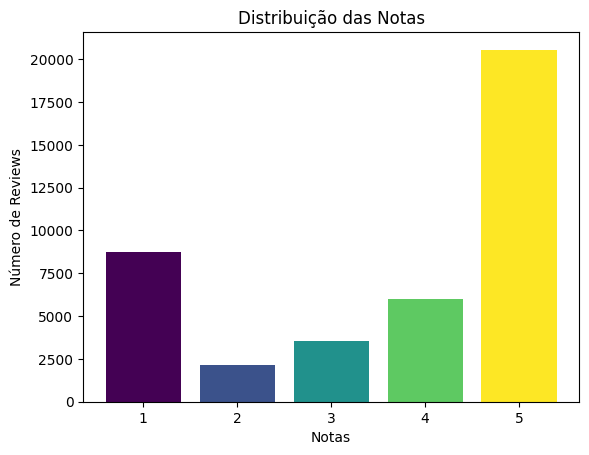

In [15]:
# Obtendo os valores únicos de review_score e suas contagens
unique_scores = np.unique(data_clean["review_score"])
counts = [list(data_clean["review_score"]).count(i) for i in unique_scores]

# Criando o gráfico de barras
plt.bar(unique_scores, counts,color=colors[:len(unique_scores)])

# Adicionando títulos e rótulos aos eixos
plt.xlabel("Notas")
plt.ylabel("Número de Reviews")
plt.title("Distribuição das Notas")

# Exibindo o gráfico
plt.show()

In [16]:
# Filtrar e mapear os rótulos
binary_data = data_clean[data_clean['review_score'].isin([1, 2, 4, 5])]
score_map = {1: 0, 2: 0, 4: 1, 5: 1}
binary_data['binary_label'] = binary_data['review_score'].map(score_map)
binary_data = binary_data[['texto', 'binary_label']]

<ipython-input-16-b58038ed8af3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['binary_label'] = binary_data['review_score'].map(score_map)


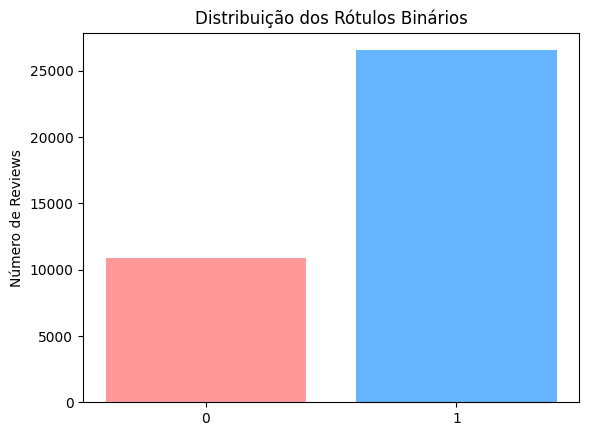

In [25]:
unique_labels = np.unique(binary_data["binary_label"])
counts = [list(binary_data["binary_label"]).count(i) for i in unique_labels]

# Definindo cores mais suaves (tons pastéis)
colors = ['#ff9999','#66b3ff']  # Rosa claro e azul claro

# Criando o gráfico de barras
bars = plt.bar(['0', '1'], counts, color=colors)

# Adicionando títulos e rótulos aos eixos
plt.ylabel("Número de Reviews")
plt.title("Distribuição dos Rótulos Binários")

# Exibindo o gráfico
plt.show()

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

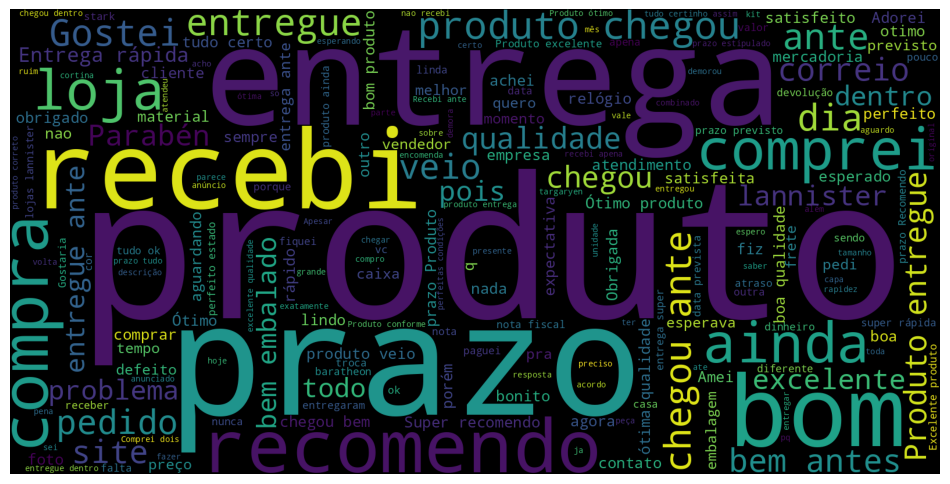

In [ ]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(binary_data["texto"]))
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

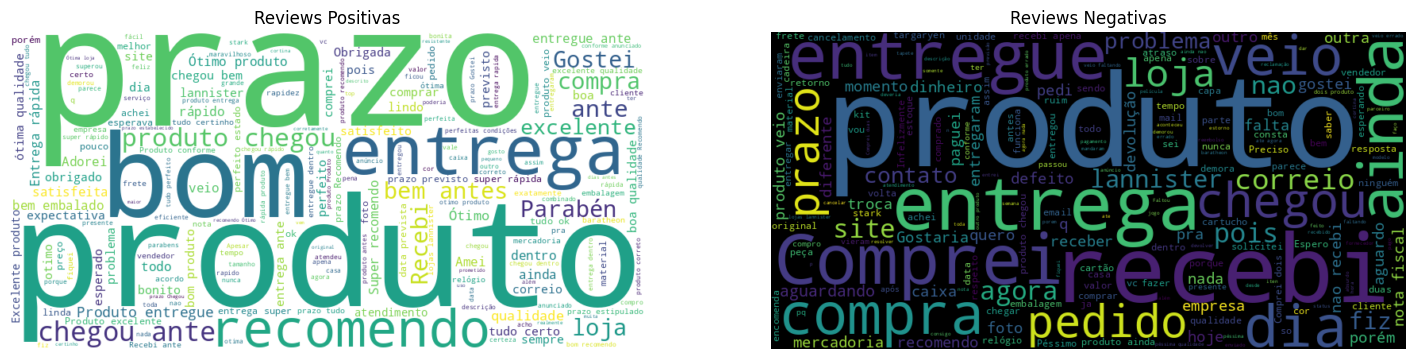

In [ ]:
positive_reviews = binary_data[binary_data['binary_label'] == 1]['texto']
negative_reviews = binary_data[binary_data['binary_label'] == 0]['texto']

wordcloud_positive = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(' '.join(positive_reviews))

wordcloud_negative = WordCloud(stopwords=stop_words, background_color="black", width=800, height=400).generate(' '.join(negative_reviews))

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[0].set_title('Reviews Positivas')
ax[0].axis('off')

ax[1].imshow(wordcloud_negative, interpolation='bilinear')
ax[1].set_title('Reviews Negativas')
ax[1].axis('off')

plt.show()

In [ ]:
data_clean.head()

,texto,review_score
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5
9,aparelho eficiente. no site a marca do aparelh...,4
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
15,"Vendedor confiável, produto ok e entrega antes...",5


In [ ]:
binary_data.head()

,texto,binary_label
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1
9,aparelho eficiente. no site a marca do aparelh...,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,"Vendedor confiável, produto ok e entrega antes...",1


In [ ]:
def clean_review_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'R\$', 'dinheiro', text, flags=re.IGNORECASE)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = text.lower()
    return text

In [ ]:
# Aplicar a função de limpeza (opcional)
binary_data["texto"] = binary_data["texto"].apply(clean_review_text)

In [ ]:
binary_data['sentimento_nome'] = pd.Categorical.from_codes(binary_data['binary_label'],['negativo','positivo'])

#Abordagem 1 - TF-IDF

In [ ]:
#instanciando o vetor
vectorizer = TfidfVectorizer(max_features=300, max_df=0.8, min_df=7)

#vetorizando e transformando em array
comentarios_vectorized = vectorizer.fit_transform(binary_data["texto"]).toarray()

#extraindo o nome das features
comentarios_features = vectorizer.get_feature_names_out()


print(comentarios_vectorized.shape)
#print(comentarios_vectorized.A) #vizualização da matriz

(37420, 300)


In [ ]:
#matriz BoW
binary_data_comentarios_vectorized = pd.DataFrame(data = comentarios_vectorized, columns = comentarios_features)
binary_data_comentarios_vectorized

,acabamento,achei,acho,acordo,adorei,agora,aguardando,aguardo,ainda,além,...,veio,vendedor,vez,vezes,vieram,vocês,volta,vou,ótima,ótimo
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.313824,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.292298,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.571966,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37415,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37416,0.0,0.0,0.0,0.528813,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37417,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37418,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#train_test_split params(X vetorizados, y array(labels), tamanho do conj teste, random_state ???)
X_treino, X_teste, y_treino, y_teste = train_test_split(comentarios_vectorized, binary_data['binary_label'].values, test_size = 0.20, random_state = 42)

print('X_treino shape ',X_treino.shape)
print('X_teste shape ',X_teste.shape)
print('y_treino shape ',y_treino.shape)
print('y_teste shape',y_teste.shape)

X_treino shape  (29936, 300)
X_teste shape  (7484, 300)
y_treino shape  (29936,)
y_teste shape (7484,)


##Multinomial Naive Bayes

In [ ]:
#treinando o modelo
classificador = MultinomialNB() #instanciando o modelo de ML navie bayes-multinomial
classificador.fit(X_treino, y_treino)

MultinomialNB()

In [ ]:
predicao = classificador.predict(X_teste) #predicoes feitas pelo modelo
proba = classificador.predict_proba(X_teste) #probabilidade de cada classe proba[0] = negatividade, proba[1] = positividade

Relatório de Classificação - Teste:
                 precision    recall  f1-score   support

Review Negativa       0.83      0.85      0.84      2191
Review Positiva       0.94      0.93      0.93      5293

       accuracy                           0.90      7484
      macro avg       0.88      0.89      0.89      7484
   weighted avg       0.91      0.90      0.90      7484



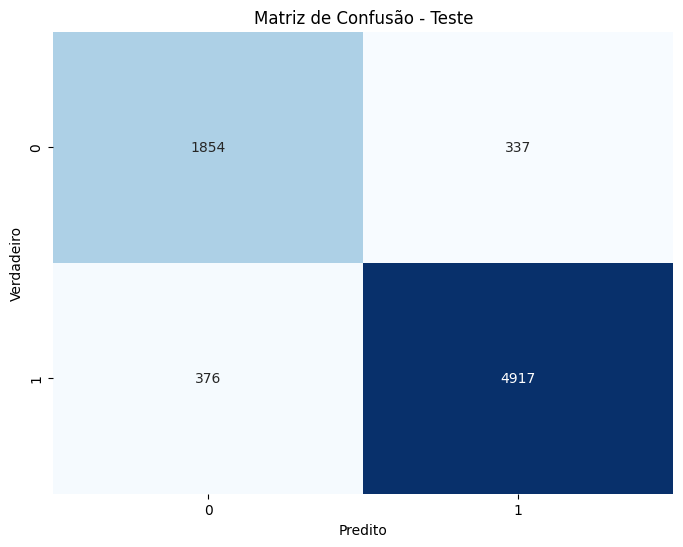

Acurácia no Teste: 0.90


In [ ]:
# Relatório de Classificação para o conjunto de teste
print("Relatório de Classificação - Teste:")
print(classification_report(y_teste, predicao, target_names=['Review Negativa', 'Review Positiva']))

# Matriz de Confusão para o conjunto de teste
conf_matrix = confusion_matrix(y_teste, predicao)

# Visualizando a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Acurácia do modelo no conjunto de teste
test_accuracy = classificador.score(X_teste, y_teste)
print(f'Acurácia no Teste: {test_accuracy:.2f}')

In [ ]:
def new_review(text, model, vectorizer):
    # Limpeza do texto
    clean_text = clean_review_text(text)

    # Vetorização do texto limpo
    vec_text = vectorizer.transform([clean_text]).toarray()  # Use transform, não fit_transform

    # Fazendo a previsão
    prediction = model.predict(vec_text)
    proba = model.predict_proba(vec_text)

    return prediction, proba

# Exemplo de uso
text = "Infelizmente não chega aos pés do 4 Quiseram inovar com o 'mundo aberto', mas é vazio, os inimigos estão espalhados no mapa e são bem poucos, reduziram as armas e armadilhas(poxa tiraram a armadilha mais famosa do jogo) O jogo parece divertido no começo, mas depois fica bem chato e enjoativo sem nada pra fazer Espere uma promoção"

# Certifique-se de passar o vetor TF-IDF treinado e o classificador
predicao, proba = new_review(text, classificador, vectorizer)

print(f"Previsão: {predicao[0]}")
print(f"Probabilidade de Negativo: {proba[0][0]:.2f}")
print(f"Probabilidade de Positivo: {proba[0][1]:.2f}")

Previsão: 1
Probabilidade de Negativo: 0.49
Probabilidade de Positivo: 0.51


#Abordagem 2 Embedding Pré Treinado

##LSTM

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/GabrielVCoutinho/Machine_Learning/main/olist_order_reviews_dataset.csv")
data_clean = data.dropna(subset=['review_comment_message'])
data_clean = data_clean.rename(columns={'review_comment_message': 'texto'})
data_clean = data_clean[['texto', 'review_score']]

In [ ]:
# Filtrar e mapear os rótulos
binary_data = data_clean[data_clean['review_score'].isin([1, 2, 4, 5])]
score_map = {1: 0, 2: 0, 4: 1, 5: 1}
binary_data['binary_label'] = binary_data['review_score'].map(score_map)
binary_data = binary_data[['texto', 'binary_label']]

def clean_review_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'R\$', 'dinheiro', text, flags=re.IGNORECASE)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = text.lower()
    return text

# Aplicar a função de limpeza
binary_data["texto"] = binary_data["texto"].apply(clean_review_text)

# Dividir os dados em conjuntos de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(binary_data["texto"], binary_data['binary_label'].values, test_size=0.20, random_state=42)

<ipython-input-31-f17e7517a894>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(X_treino)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X_treino)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_teste)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Carregar os embeddings
embedding_dim = 100

embedding_file = '/content/cbow_s100.txt'

# Carregar os embeddings
embeddings_index = {}
with open(embedding_file, encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Total de vetores de palavras: {len(embeddings_index)}')

# 3. Preparar a Matriz de Embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Palavras encontradas nos embeddings pré-treinados
        embedding_matrix[i] = embedding_vector
    else:
        # Palavras não encontradas são inicializadas aleatoriamente
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

Total de vetores de palavras: 929607


In [ ]:
def create_model_lstm():
    input = tf.keras.Input(shape=(max_length,))

    # Camada de Embedding Treinável
    x = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True
    )(input)

    # Adicionar Conv1D
    x = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    # LSTM Bidirecional
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)
    )(x)

    # Dropout e BatchNormalization
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Camada Densa com Regularização L2
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout adicional

    # Saída
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=input, outputs=output)

with tf.device('/GPU:0'):
    model = create_model_lstm()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Alterado para Adam
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    training_padded,
    y_treino,
    validation_data=(testing_padded, y_teste),
    epochs=20,
    batch_size=128,
    callbacks=[earlyStoppingCallback],
)

Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 135s 510ms/step - accuracy: 0.7847 - loss: 0.9927 - val_accuracy: 0.9198 - val_loss: 0.3295
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 117s 502ms/step - accuracy: 0.9286 - loss: 0.2618 - val_accuracy: 0.9348 - val_loss: 0.1957
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 137s 480ms/step - accuracy: 0.9487 - loss: 0.1723 - val_accuracy: 0.9325 - val_loss: 0.2020
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 116s 496ms/step - accuracy: 0.9583 - loss: 0.1430 - val_accuracy: 0.9299 - val_loss: 0.1918
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 144s 503ms/step - accuracy: 0.9678 - loss: 0.1180 - val_accuracy: 0.9284 - val_loss: 0.1952
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 143s 507ms/step - accuracy: 0.9732 - loss: 0.1057 - val_accuracy: 0.9272 - val_loss: 0.2254
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 140s 500ms/step - accuracy: 0.9772 - loss: 0.0896 - val_accuracy: 0.9325 - val_loss: 0.2554
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 136s 471ms/step - accuracy: 0.9808 -

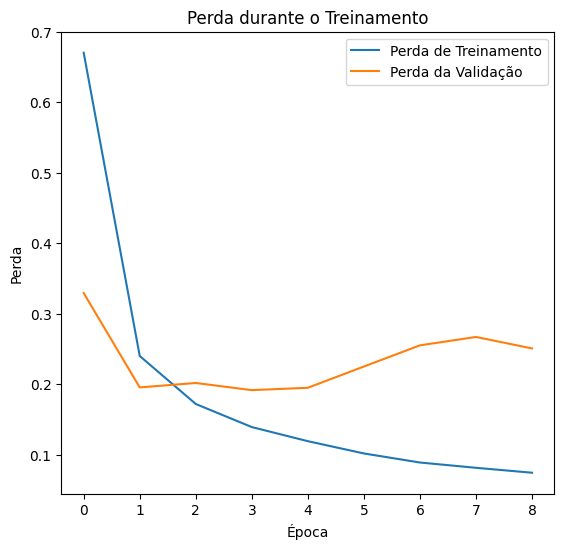

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda da Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

In [ ]:
y_pred_prob = model.predict(testing_padded)
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)
y_true = y_teste.reshape(-1)

234/234 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step


In [ ]:
print("\nRelatório de Classificação:\n", classification_report(y_true, y_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      2191
           1       0.96      0.95      0.95      5293

    accuracy                           0.93      7484
   macro avg       0.92      0.92      0.92      7484
weighted avg       0.94      0.93      0.94      7484



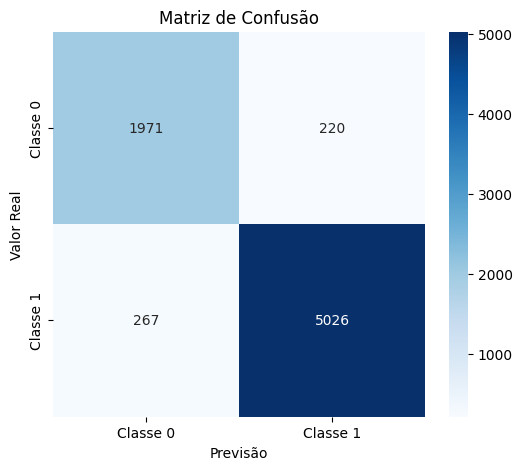

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.title('Matriz de Confusão')
plt.show()


In [ ]:
# 8. Calcular AUC-ROC
auc = roc_auc_score(y_true, y_pred_prob)
print(f'AUC-ROC: {auc:.4f}')

AUC-ROC: 0.9770


In [ ]:
def new_review_dl(text, model, tokenizer, max_length=120, padding_type='post', trunc_type='post'):

    clean_text = clean_review_text(text)

    sequences = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # 3. Fazer a previsão
    proba = model.predict(padded)[0][0]
    prediction = int(proba >= 0.5)

    return prediction, proba

In [ ]:
# Exemplo de uso
novo_texto = "O forno é lindo, custo benefício ok! Porém ao fazer algo de fritura ou algo que seja de espirrar, utilizem algo de silicone ou que proteja, pois dá muito trabalho pra limpar, e espirra tudo na porta de vidro."

predicao, proba = new_review_dl(novo_texto, model, tokenizer)

print(f"Previsão: {predicao}")
print(f"Probabilidade de Negativo: {1 - proba:.2f}")
print(f"Probabilidade de Positivo: {proba:.2f}")

##GRU

In [ ]:
def create_model_gru():
    input = tf.keras.Input(shape=(max_length,))

    # Camada de Embedding Treinável
    x = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True
    )(input)

    # Adicionar Conv1D (opcional: pode ser removido para teste)
    x = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    # GRU Bidirecional com dropout reduzido
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(64, dropout=0.2)
    )(x)

    # Dropout e BatchNormalization
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Camada Densa com Regularização L2 reduzida
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
    x = tf.keras.layers.Dropout(0.3)(x)  # Dropout adicional

    # Saída
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=input, outputs=output)

In [ ]:
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
with tf.device(device):
    model = create_model_gru()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    training_padded,
    y_treino,
    validation_data=(testing_padded, y_teste),
    epochs=20,
    batch_size=128,
    callbacks=[earlyStoppingCallback],
)

Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.8144 - loss: 0.6617 - val_accuracy: 0.9189 - val_loss: 0.2759
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9308 - loss: 0.2349 - val_accuracy: 0.9206 - val_loss: 0.2217
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9550 - loss: 0.1519 - val_accuracy: 0.9226 - val_loss: 0.2082
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9647 - loss: 0.1193 - val_accuracy: 0.9198 - val_loss: 0.2139
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9726 - loss: 0.0954 - val_accuracy: 0.9221 - val_loss: 0.2351
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9789 - loss: 0.0803 - val_accuracy: 0.9114 - val_loss: 0.3033
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9832 - loss: 0.0654 - val_accuracy: 0.9157 - val_loss: 0.2956
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9841 - loss: 0.0650 - val_ac

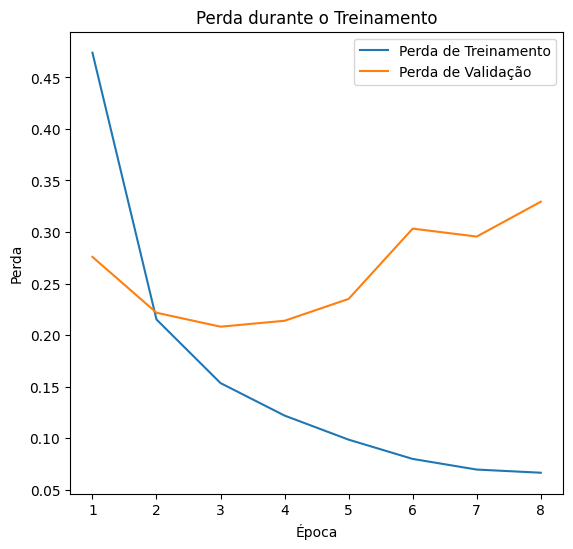

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
epochs_range = range(1, len(history.history['loss']) + 1)
plt.plot(epochs_range, history.history['loss'], label='Perda de Treinamento')
plt.plot(epochs_range, history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

In [ ]:
y_pred_prob = model.predict(testing_padded)
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)
y_true = y_teste.reshape(-1)

234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [ ]:
print("\nRelatório de Classificação:\n", classification_report(y_true, y_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      2191
           1       0.97      0.91      0.94      5293

    accuracy                           0.92      7484
   macro avg       0.90      0.93      0.91      7484
weighted avg       0.93      0.92      0.92      7484



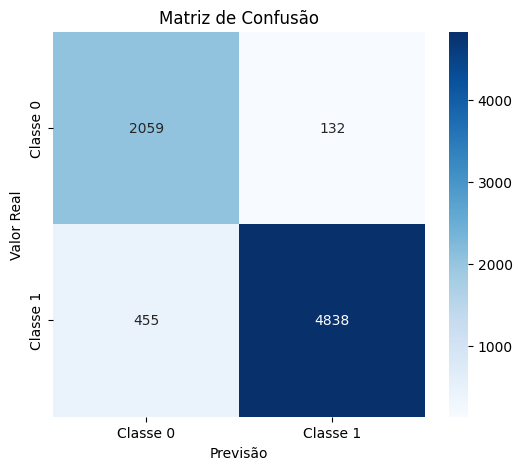

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
# 8. Calcular AUC-ROC
auc = roc_auc_score(y_true, y_pred_prob)
print(f'AUC-ROC: {auc:.4f}')

AUC-ROC: 0.9735


In [ ]:
novo_texto = "O forno é lindo, custo benefício ok! Porém ao fazer algo de fritura ou algo que seja de espirrar, utilizem algo de silicone ou que proteja, pois dá muito trabalho pra limpar, e espirra tudo na porta de vidro."

predicao, proba = new_review_dl(novo_texto, model, tokenizer)

print(f"Previsão: {predicao}")
print(f"Probabilidade de Negativo: {1 - proba:.2f}")
print(f"Probabilidade de Positivo: {proba:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Previsão: 1
Probabilidade de Negativo: 0.36
Probabilidade de Positivo: 0.64
